##  **Audio Sound source Separation Using Non-Negative Matrix Factorization**




**Import libraries**

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import librosa
import librosa.display
import IPython.display as ipd

### **01. Prepare the data**

**Load audio recording**

In [2]:
audio_file = '/kaggle/input/ank-data2/DrumBass.wav'

**Listen to audio recording**

In [3]:
sample_rate = 5512
# Load audio signal
audio_sound, sr = librosa.load(audio_file, sr = sample_rate)
# Display audio
ipd.Audio(audio_sound,rate = sr)

In [4]:
print(audio_sound.shape)

(36111,)


**Show the sound's waveform**

In [5]:
print(audio_sound)

[ 0.01181798 -0.00983938  0.03130849 ... -0.00917564  0.00062168
 -0.02352253]


/tmp/ipykernel_20/3700569416.py:3: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(audio_sound, sr=sr, ax=ax,x_axis='time')


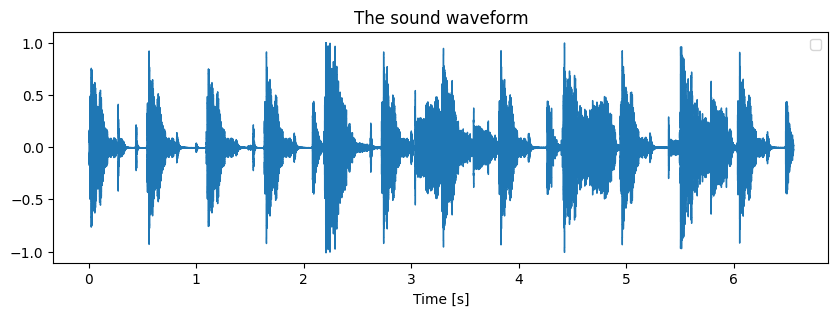

In [6]:
# Plotting the sound's waveform
fig, ax = plt.subplots(figsize=(10, 3))
librosa.display.waveshow(audio_sound, sr=sr, ax=ax,x_axis='time')
ax.set(title='The sound waveform',
       xlabel='Time [s]')
ax.legend()

### **02. Compute Short Term Fourier Transform of the signal**

In [7]:
FRAME = 512
HOP = 256

# Return the complex Short Term Fourier Transform
sound_stft = librosa.stft(audio_sound, n_fft = FRAME, hop_length = HOP)

In [8]:
# # Calculate the STFT
# spectrogram = librosa.stft(audio_sound, n_fft=FRAME, hop_length=HOP)

# # Convert the magnitude spectrogram to dB scale
# spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram))

# # Plot the spectrogram
# plt.figure(figsize=(12, 6))
# librosa.display.specshow(spectrogram_db, sr=sr, hop_length=HOP, x_axis='time', y_axis='linear', cmap='jet')
# plt.colorbar(format="%+2.0f dB")
# plt.title('Spectrogram (Frequency vs. Time)')
# plt.xlabel('Time (s)')
# plt.ylabel('Frequency (Hz)')
# plt.show()

Text(0.5, 1.0, 'Audio spectrogram')

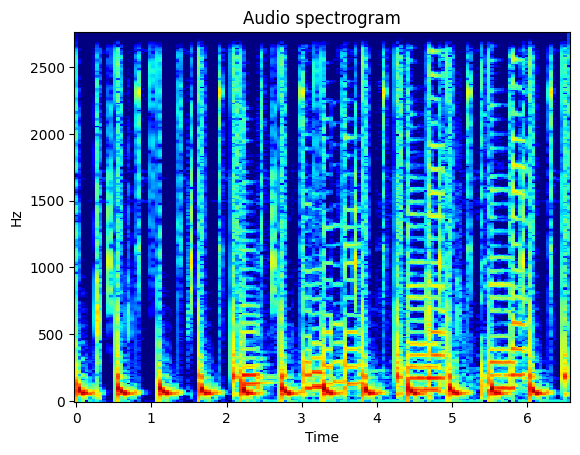

In [9]:
# Magnitude Spectrogram
sound_stft_Magnitude = np.abs(sound_stft)

# Phase spectrogram
sound_stft_Angle = np.angle(sound_stft)

# Plot Spectogram
Spec = librosa.amplitude_to_db(sound_stft_Magnitude, ref = np.max)
librosa.display.specshow(Spec,y_axis = 'hz',sr=sr,hop_length=HOP,x_axis ='time',cmap= matplotlib.cm.jet)
plt.title('Audio spectrogram')

# Spec = librosa.amplitude_to_db(sound_stft_Angle, ref = np.max)
# librosa.display.specshow(Spec,y_axis = 'hz',sr=sr,hop_length=HOP,x_axis ='time',cmap= matplotlib.cm.jet)
# plt.title('Audio spectrogram')

### **03. Non-Negative Matrix Factorisation**

**Define a fonction that computes the $\beta$ Divergence**

In [10]:
epsilon = 1e-10 # error to introduce
V = sound_stft_Magnitude + epsilon
K, N = np.shape(V)
S = 2
print(f"S = {S} : Number of Sources to separate")

S = 2 : Number of Sources to separate


In [11]:
V.shape

(257, 142)

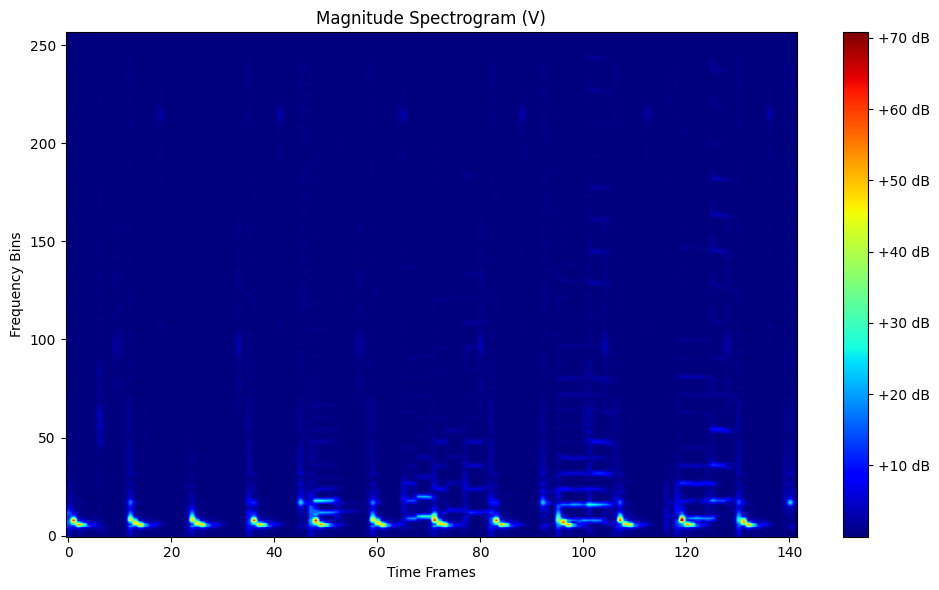

In [12]:
import matplotlib.pyplot as plt

# Assuming you have already defined the V matrix
# V = sound_stft_Magnitude + epsilon

# Plot the magnitude spectrogram V
plt.figure(figsize=(10, 6))
plt.imshow(V, aspect='auto', origin='lower', cmap='jet')
plt.colorbar(format='%+2.0f dB')
plt.title('Magnitude Spectrogram (V)')
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')
plt.tight_layout()
plt.show()


In [13]:
print(np.max(V))

70.75494


In [14]:
print(np.min(V))

6.996898e-08


In [15]:
def divergence(V,W,H, beta = 2):
    
    """
    beta = 2 : Euclidean cost function
    beta = 1 : Kullback-Leibler cost function
    beta = 0 : Itakura-Saito cost function
    """ 
    
    if beta == 0 : return np.sum( V/(W@H) - math.log10(V/(W@H)) -1 )
    
    if beta == 1 : return np.sum( V*math.log10(V/(W@H)) + (W@H - V))
    
    if beta == 2 : return 1/2*np.linalg.norm(W@H-V)
    

**Define a visualization function**

In [16]:
def plot_NMF_iter(W, H,beta,iteration = None):
    
    f = plt.figure(figsize=(4,4))
    f.suptitle(f"NMF Iteration {iteration}, for beta = {beta}", fontsize=8,)
    
    # definitions for the axes
    V_plot = plt.axes([0.35, 0.1, 1, 0.6])
    H_plot = plt.axes([0.35, 0.75, 1, 0.15])
    W_plot = plt.axes([0.1, 0.1, 0.2, 0.6])

    D = librosa.amplitude_to_db(W@H , ref = np.max)

    librosa.display.specshow(W,y_axis = 'hz', sr=sr, hop_length=HOP,x_axis ='time',cmap= matplotlib.cm.jet, ax=W_plot)
    librosa.display.specshow(H,y_axis = 'hz', sr=sr, hop_length=HOP,x_axis ='time',cmap= matplotlib.cm.jet, ax=H_plot)
    librosa.display.specshow(D,y_axis = 'hz', sr=sr, hop_length=HOP,x_axis ='time',cmap= matplotlib.cm.jet, ax=V_plot)

    W_plot.set_title('Dictionnary W', fontsize=10)
    H_plot.set_title('Temporal activations H', fontsize=10)

    W_plot.axes.get_xaxis().set_visible(False)
    H_plot.axes.get_xaxis().set_visible(False)
    V_plot.axes.get_yaxis().set_visible(False)

**Define main NMF function**

In [17]:
def update_step(X,H,W):
    p,n = X.shape
    r = H.shape[0]
# W <-- W .* ( [X*H'] ./ [W*H*H'] )
    x_ = np.matmul(W,H)
    for i in range(p):
        for j in range(r):
            w_ij_num = max(0,np.inner(X[i][:],H[j][:]))
            w_ij_denom = max(0,np.inner(x_[i][:],H[j][:]))
            if w_ij_num>0 and w_ij_denom>0:
                W[i][j] *= w_ij_num
                W[i][j] /= w_ij_denom
    return W

In [18]:
def update_beta_step(V,H,W,beta):
    
    H_new *= (W.T@(((W@H)**(beta-2))*V))/(W.T@((W@H)**(beta-1)) + 10e-10)
    W_new *= (((W@H)**(beta-2)*V)@H.T)/((W@H)**(beta-1)@H.T + 10e-10)
    return W_new,H_new 
    

In [19]:
def NMF(V, S, beta = 2,  threshold = 0.05, MAXITER = 5000, display = True , displayEveryNiter = None): 
    
    """
    inputs : 
    --------
    
        V         : Mixture signal : |TFST|
        S         : The number of sources to extract
        beta      : Beta divergence considered, default=2 (Euclidean)
        threshold : Stop criterion 
        MAXITER   : The number of maximum iterations, default=1000
        display   : Display plots during optimization : 
        displayEveryNiter : only display last iteration 
                                                            
    
    outputs :
    ---------
      
        W : dictionary matrix [KxS], W>=0
        H : activation matrix [SxN], H>=0
        cost_function : the optimised cost function over iterations
       
   Algorithm : 
   -----------
   
    1) Randomly initialize W and H matrices
    2) Multiplicative update of W and H 
    3) Repeat step (2) until convergence or after MAXITER 
    
       
    """
    counter  = 0
    cost_function = []
    beta_divergence = 1
    
    K, N = np.shape(V)
    
    # Initialisation of W and H matrices : The initialization is generally random
    W = np.abs(np.random.normal(loc=0, scale = 2.5, size=(K,S)))    
    H = np.abs(np.random.normal(loc=0, scale = 2.5, size=(S,N)))
    
    # Plotting the first initialization
    if display == True : plot_NMF_iter(W,H,beta,counter)


    while beta_divergence >= threshold and counter <= MAXITER:
        
        # Update of W and H
#         H *= (W.T@(((W@H)**(beta-2))*V))/(W.T@((W@H)**(beta-1)) + 10e-10)
#         W *= (((W@H)**(beta-2)*V)@H.T)/((W@H)**(beta-1)@H.T + 10e-10)
        W=update_step(V,H,W)
        H=update_step(V.T,W.T,H.T).T
        
        # Compute cost function
        beta_divergence =  divergence(V,W,H, beta = 2)
        print(beta_divergence)
        cost_function.append( beta_divergence )
        
        if  display == True  and counter%displayEveryNiter == 0  : plot_NMF_iter(W,H,beta,counter)

        counter +=1
    
    if counter -1 == MAXITER : print(f"Stop after {MAXITER} iterations.")
    else : print(f"Convergeance after {counter-1} iterations.")
        
    return W,H, cost_function 

**Call function**

162.3407598885759
152.23255048484
147.36840765799997
140.5872208138523
131.2935648625112
121.58914543784057
114.65188220980812
111.03807612513502
109.40913781265833
108.67978370355917
108.32723647768746
108.13703882045355
108.02241985932639
107.94690866740076
107.8941534969606
107.85600503384993
107.82780173728194
107.80655192770266
107.79022069579946
107.777402313707
107.7671257680322
107.7587196558773
107.75171614908612
107.7457846677888
107.74068741699176
107.73625004756018
107.73234232568794
107.72886528375065
107.72574255195322
107.7229144051922
107.72033359438288
107.71796236720749
107.71577029458709
107.71373265362513
107.71182920387496
107.71004324888415
107.7083609099985
107.7067705615187
107.70526239025725
107.70382805154313
107.70246039985696
107.70115327684763
107.69990134317233
107.69869994371054
107.6975449982981
107.69643291221145
107.69536050221193
107.69432493509663
107.69332367648272
107.6923544480736
107.69141519200497
107.69050404111402
107.68961929415775
107.688759

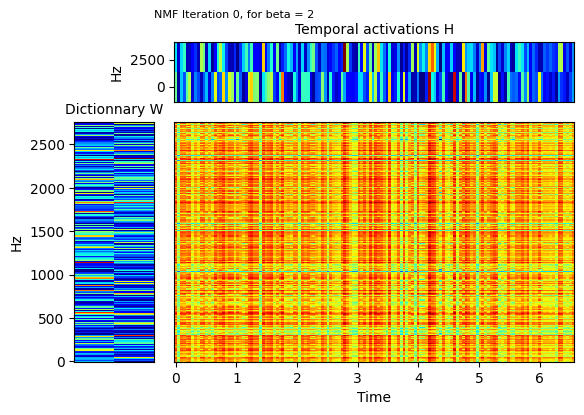

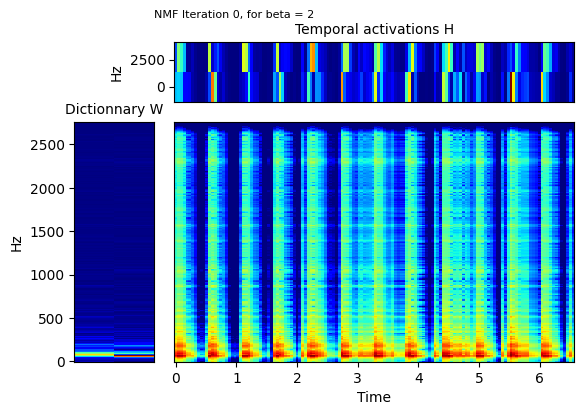

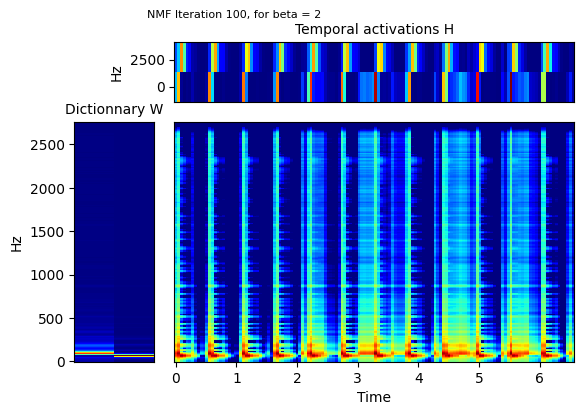

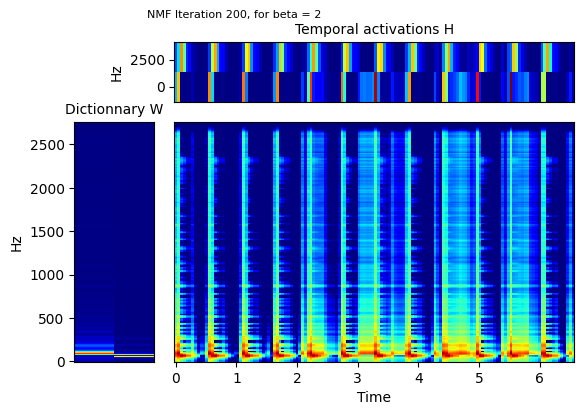

In [20]:
beta = 2
W, H, cost_function = NMF(V,S,beta = beta, threshold = 0.05, MAXITER = 200, display = True , displayEveryNiter = 100)   

**Plotting the cost Function**

Text(0, 0.5, 'Beta Divergence for beta = 2 ')

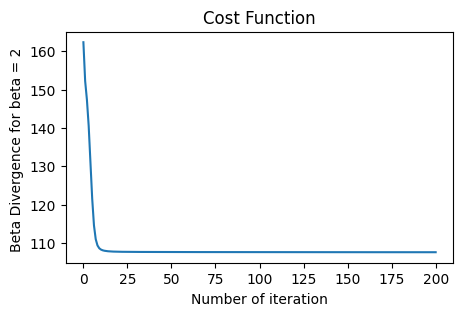

In [21]:
# Plot the cost function
plt.figure(figsize=(5,3))
plt.plot(cost_function)
plt.title("Cost Function")
plt.xlabel("Number of iteration")
plt.ylabel(f"Beta Divergence for beta = {beta} ")

### **04. Filtering off the different sources**

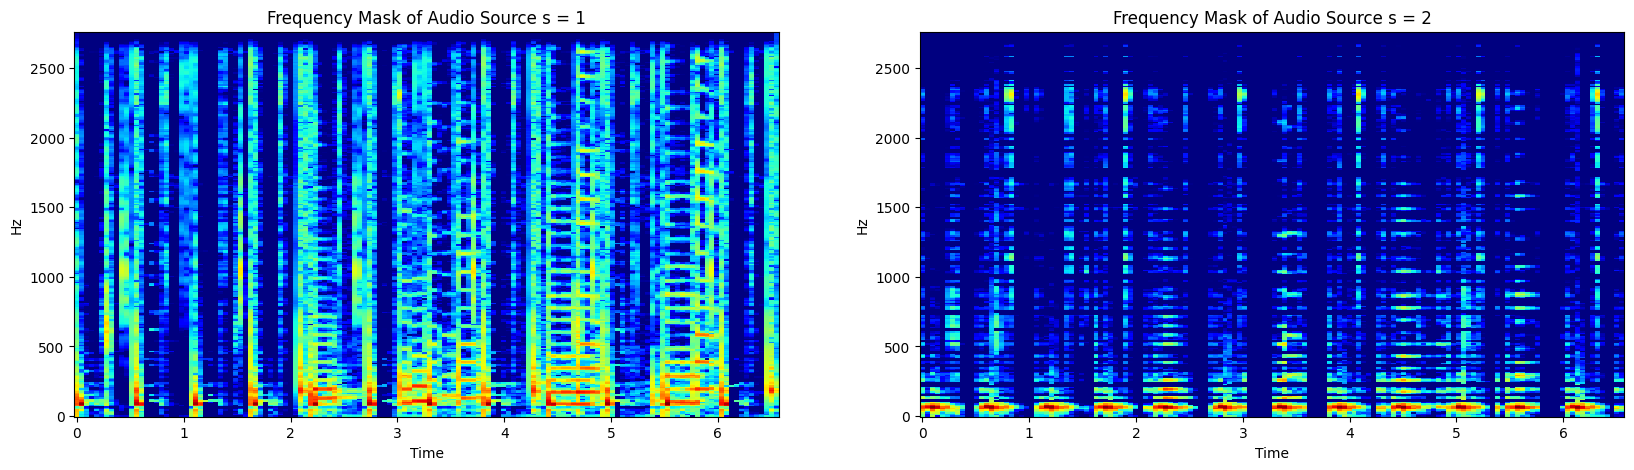

In [22]:
#After NMF, each audio source S can be expressed as a frequency mask over time
f, axs = plt.subplots(nrows=1, ncols=S,figsize=(20,5))
filtered_spectrograms = []
for i in range(S):
    axs[i].set_title(f"Frequency Mask of Audio Source s = {i+1}") 
    # Filter eash source components
    WsHs = W[:,[i]]@H[[i],:]
    filtered_spectrogram = W[:,[i]]@H[[i],:] /(W@H) * V 
    # Compute the filtered spectrogram
    D = librosa.amplitude_to_db(filtered_spectrogram, ref = np.max)
    # Show the filtered spectrogram
    librosa.display.specshow(D,y_axis = 'hz', sr=sr,hop_length=HOP,x_axis ='time',cmap= matplotlib.cm.jet, ax = axs[i])
    
    filtered_spectrograms.append(filtered_spectrogram)

### **05. Reconstruction the different audio signal corresponding to each extracted source**

In [23]:
reconstructed_sounds = []
for i in range(S):
    reconstruct = filtered_spectrograms[i] * np.exp(1j*sound_stft_Angle)
    new_sound   = librosa.istft(reconstruct, n_fft = FRAME, hop_length = HOP)
    reconstructed_sounds.append(new_sound)

/tmp/ipykernel_20/2813132796.py:5: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(reconstructed_sounds[i], sr=sr, color = colors[i], ax=ax[i],label=f'Source {i}',x_axis='time')


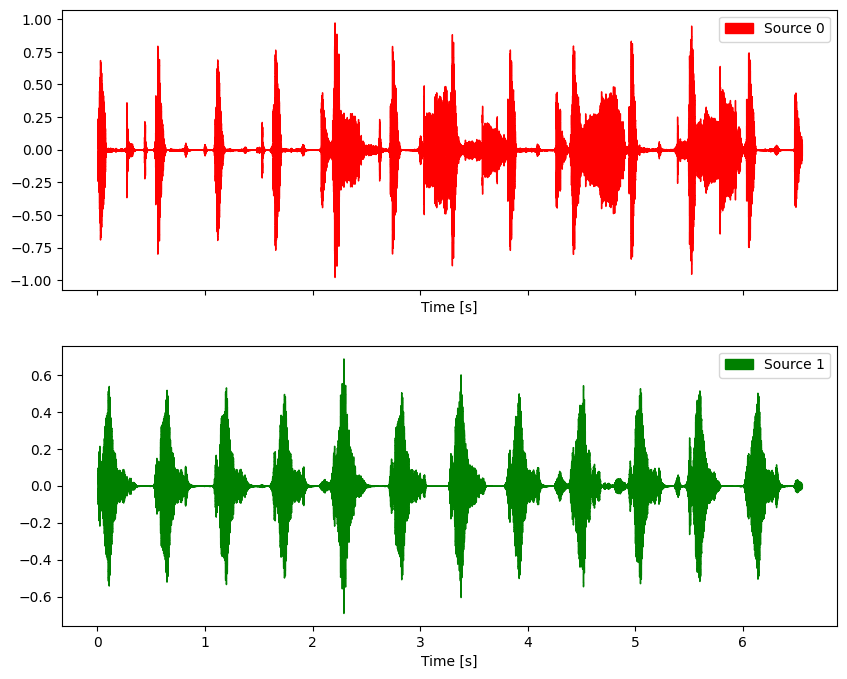

In [24]:
# Plotting the waveform
colors = ['r', 'g','b','c']
fig, ax = plt.subplots(nrows=S, ncols=1, sharex=True, figsize=(10, 8))
for i in range(S):
    librosa.display.waveshow(reconstructed_sounds[i], sr=sr, color = colors[i], ax=ax[i],label=f'Source {i}',x_axis='time')
    ax[i].set(xlabel='Time [s]')
    ax[i].legend()

**Playing The extracted signals**

In [25]:
for i in range(S):
    ipd.display(f"Source {i}",ipd.Audio(reconstructed_sounds[i], rate=sr))

'Source 0'

'Source 1'

/tmp/ipykernel_20/4019249474.py:7: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(superimposed_sound, sr=sr, color='m', label='Superimposed Sound', x_axis='time')


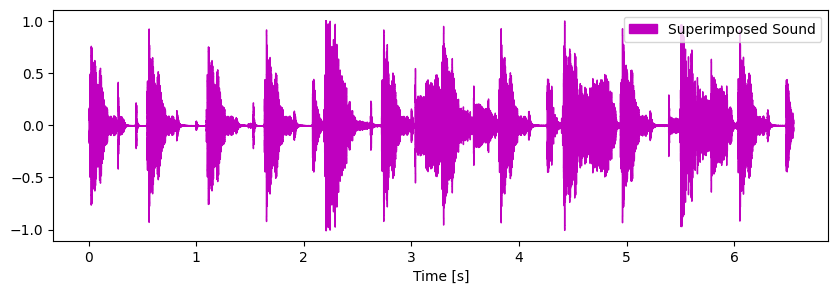

In [26]:
# Superimpose the reconstructed sounds
from sklearn.metrics import mean_squared_error
superimposed_sound = sum(reconstructed_sounds)

# Plot the superimposed waveform
plt.figure(figsize=(10, 3))
librosa.display.waveshow(superimposed_sound, sr=sr, color='m', label='Superimposed Sound', x_axis='time')
plt.xlabel('Time [s]')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
min_length = min(len(audio_sound), len(superimposed_sound))
audio_sound = audio_sound[:min_length]
superimposed_sound = superimposed_sound[:min_length]

# Calculate the MSE between the original sound and the superimposed sound
mse_superimposed = mean_squared_error(audio_sound, superimposed_sound)

# Calculate the MSE between the original sound and each separated sound
mse_individual = []
for i in range(S):
    # Truncate or resize the separated sound to match the length of 'audio_sound'
    reconstructed_sound = reconstructed_sounds[i][:min_length]
    mse = mean_squared_error(audio_sound, reconstructed_sound)
    mse_individual.append(mse)

# Print or use the MSE scores to measure resemblance
print(f"MSE between Original Sound and Superimposed Sound: {mse_superimposed}")

for i in range(S):
    print(f"MSE between Original Sound and Source {i}: {mse_individual[i]}")
    
cosine_sim = cosine_similarity(audio_sound.reshape(1, -1), superimposed_sound.reshape(1, -1))

print(f"Cosine Similarity between Original Sound and Superimposed Sound: {cosine_sim[0, 0]}")

MSE between Original Sound and Superimposed Sound: 7.863512201023068e-17
MSE between Original Sound and Source 0: 0.015281783208334348
MSE between Original Sound and Source 1: 0.02046665089142959
Cosine Similarity between Original Sound and Superimposed Sound: 0.9999999999999984


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Generate synthetic data (replace this with your own data)
np.random.seed(42)
matrix = np.random.rand(100, 50)  # Replace with your matrix dimensions

# Define the number of components (rank) for NMF
n_components = 2

# Convert the matrix to a PyTorch tensor
matrix = torch.tensor(matrix, dtype=torch.float32)

# Define a neural network model for NMF-like factorization
class NMFModel(nn.Module):
    def __init__(self, n_features, n_components):
        super(NMFModel, self).__init__()
        self.W = nn.Parameter(torch.rand(n_features, n_components))  # Factor W
        self.H = nn.Parameter(torch.rand(n_components, matrix.shape[1]))  # Factor H

    def forward(self):
        # Apply non-negativity constraint to factors and set negative values to zero
        W = torch.relu(self.W)
        H = torch.relu(self.H)
        return torch.mm(W, H)

# Create the model and optimizer
model = NMFModel(matrix.shape[0], n_components)
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    predicted_matrix = model()
    
    # Calculate the reconstruction loss (you can customize this)
    loss = nn.MSELoss()(predicted_matrix, matrix)
#     print("cost "+loss)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Apply non-negativity constraint to factors and set negative values to zero
    model.W.data = torch.relu(model.W.data)
    model.H.data = torch.relu(model.H.data)
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Get the learned factors W and H
W = model.W.detach().numpy()
H = model.H.detach().numpy()

# Now, W and H contain the approximate factorization of the input matrix with non-negative constraints


Epoch [100/1000], Loss: 0.1728706955909729
Epoch [200/1000], Loss: 0.16959144175052643
Epoch [300/1000], Loss: 0.1664963662624359
Epoch [400/1000], Loss: 0.1635713428258896
Epoch [500/1000], Loss: 0.16080357134342194
Epoch [600/1000], Loss: 0.15818148851394653
Epoch [700/1000], Loss: 0.15569452941417694
Epoch [800/1000], Loss: 0.15333309769630432
Epoch [900/1000], Loss: 0.1510883867740631
Epoch [1000/1000], Loss: 0.1489524394273758


In [29]:
print(matrix)

tensor([[0.3745, 0.9507, 0.7320,  ..., 0.5201, 0.5467, 0.1849],
        [0.9696, 0.7751, 0.9395,  ..., 0.4275, 0.0254, 0.1079],
        [0.0314, 0.6364, 0.3144,  ..., 0.5027, 0.0515, 0.2786],
        ...,
        [0.9813, 0.3816, 0.7752,  ..., 0.2980, 0.0898, 0.9108],
        [0.0060, 0.4839, 0.1232,  ..., 0.7416, 0.8051, 0.8450],
        [0.3951, 0.0513, 0.4019,  ..., 0.3278, 0.8157, 0.5973]])


In [30]:
print(W)

[[0.93904144 0.64259934]
 [0.51303357 0.26563287]
 [0.13031682 0.9338526 ]
 [0.14933823 0.2293218 ]
 [0.791169   0.04604816]
 [0.8380576  0.33919945]
 [0.64857596 0.5733007 ]
 [0.2689764  0.57064766]
 [0.26944578 0.3186104 ]
 [0.26428288 0.6232076 ]
 [0.9715353  0.15504439]
 [0.04644373 0.7722623 ]
 [0.6359569  0.3466935 ]
 [0.37732765 0.15548821]
 [0.30835065 0.63592345]
 [0.50356054 0.8540586 ]
 [0.5971779  0.78834677]
 [0.3303176  0.79446566]
 [0.8701228  0.44226134]
 [0.46356007 0.7940198 ]
 [0.43726948 0.7446507 ]
 [0.12302656 0.3016171 ]
 [0.62191767 0.72582674]
 [0.38985574 0.2025826 ]
 [0.21404673 0.8554677 ]
 [0.05162695 0.5230716 ]
 [0.42446685 0.8114525 ]
 [0.2915922  0.64443886]
 [0.80127025 0.20474063]
 [0.43142444 0.3208067 ]
 [0.42436746 0.33568704]
 [0.557524   0.89265335]
 [0.08856529 0.9303407 ]
 [0.36262128 0.0512808 ]
 [0.5100389  0.05722977]
 [0.3787883  0.15684688]
 [0.656402   0.57152396]
 [0.6333131  0.9083853 ]
 [0.13536933 0.14251715]
 [0.8229727  0.82995254]


In [31]:
print(H)

[[0.319475   0.8046573  0.8969225  0.5387438  0.478742   0.8460843
  0.8097894  0.702978   0.73033214 0.54879117 0.91962147 0.33724537
  0.7236556  0.80494887 0.57742685 0.14833121 0.7572728  0.05834566
  0.7299322  0.34296626 0.75795114 0.68685865 0.17124993 0.40594932
  0.36533913 0.18514232 0.6322248  0.4924297  0.5881599  0.1819469
  0.22237709 0.11177148 0.4701723  0.74909526 0.78335977 0.564923
  0.28620028 0.8456435  0.80184984 0.3985439  0.7916701  0.56708276
  0.09593701 0.28933385 0.0749604  0.81727564 0.5463771  0.2648943
  0.3031625  0.5876009 ]
 [0.24805522 0.6711148  0.67335767 0.83493924 0.36489052 0.7254857
  0.03690244 0.10199854 0.4415071  0.10509963 0.32343382 0.49101302
  0.4866297  0.38249746 0.13126588 0.18130498 0.17085715 0.64179075
  0.20124635 0.88578093 0.33771995 0.40928108 0.5129297  0.8937569
  0.2517116  0.88184416 0.13736098 0.44075534 0.22126997 0.68191814
  0.6178588  0.25468478 0.18714596 0.27312443 0.22436658 0.6120594
  0.8398563  0.49105617 0.22344

In [32]:
def divergence(V,W,H, beta = 2):
    
    """
    beta = 2 : Euclidean cost function
    beta = 1 : Kullback-Leibler cost function
    beta = 0 : Itakura-Saito cost function
    """ 
    
    if beta == 0 : return np.sum( V/(W@H) - math.log10(V/(W@H)) -1 )
    
    if beta == 1 : return np.sum( V*math.log10(V/(W@H)) + (W@H - V))
    
    if beta == 2 : return 1/2*np.linalg.norm(W@H-V)

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the NMF model with non-negativity constraints
class NMF(nn.Module):
    def __init__(self, K, S):
        super(NMF, self).__init__()
        self.W = nn.Parameter(torch.rand(K, S))  # Initialize W as a learnable parameter
        self.H = nn.Parameter(torch.rand(S, N))  # Initialize H as a learnable parameter
        self.beta = 2  # Choose your beta value (2 for Euclidean)
        self.relu = nn.ReLU()  # Apply ReLU to enforce non-negativity

    def forward(self, V):
        WH = torch.mm(self.W, self.H)
        WH = self.relu(WH)  # Apply ReLU to enforce non-negativity
        cost = self.compute_cost(V, WH)
        return WH, cost

    def compute_cost(self, V, WH):
        if self.beta == 0:
            return torch.sum(V / WH - torch.log(V / WH) - 1)
        elif self.beta == 1:
            return torch.sum(V * torch.log(V / WH) + (WH - V))
        elif self.beta == 2:
            return 0.5 * torch.norm(WH - V)

# Prepare the data (similar to your previous code)
epsilon = 1e-10
V = torch.Tensor(sound_stft_Magnitude + epsilon)
K, N = V.shape
S = 2

# Create the NMF model
model = NMF(K, S)

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
threshold = 0.05
MAXITER = 10000
for iteration in range(MAXITER):
    WH, cost = model(V)
    
    # Update W and H using gradient descent with non-negativity constraints
    optimizer.zero_grad()
    loss = cost
    loss.backward()
    
    # Enforce non-negativity constraints
    for param in model.parameters():
        param.data = param.data.clamp(min=0)
    
    optimizer.step()

    # Compute the cost function
    beta_divergence = cost.item()
    
    if beta_divergence < threshold:
        print(f"Converged after {iteration + 1} iterations.")
        break

    if iteration % 100 == 0:
        print(f"Iteration {iteration + 1}: Beta Divergence = {beta_divergence:.6f}")

# Get the factorized matrices
W = model.W.detach().numpy()
H = model.H.detach().numpy()

# Now, you can use W and H to filter and reconstruct the sources as in your previous code.


Iteration 1: Beta Divergence = 262.867676
Iteration 101: Beta Divergence = 256.398041
Iteration 201: Beta Divergence = 246.329285
Iteration 301: Beta Divergence = 229.721954
Iteration 401: Beta Divergence = 205.209061
Iteration 501: Beta Divergence = 178.918320
Iteration 601: Beta Divergence = 162.819031
Iteration 701: Beta Divergence = 156.828308
Iteration 801: Beta Divergence = 154.437698
Iteration 901: Beta Divergence = 152.725876
Iteration 1001: Beta Divergence = 150.521606
Iteration 1101: Beta Divergence = 146.862717
Iteration 1201: Beta Divergence = 140.629578
Iteration 1301: Beta Divergence = 131.112167
Iteration 1401: Beta Divergence = 120.184364
Iteration 1501: Beta Divergence = 112.947433
Iteration 1601: Beta Divergence = 109.751991
Iteration 1701: Beta Divergence = 108.596077
Iteration 1801: Beta Divergence = 108.143951
Iteration 1901: Beta Divergence = 107.929359
Iteration 2001: Beta Divergence = 107.811394
Iteration 2101: Beta Divergence = 107.745621
Iteration 2201: Beta D

In [34]:
V.shape


torch.Size([257, 142])

In [35]:
W.shape

(257, 2)

In [36]:
H.shape

(2, 142)

/tmp/ipykernel_20/2631031997.py:23: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(reconstructed_sources[i], sr=sr, color=colors[i], ax=ax[i], label=f'Source {i}', x_axis='time')


'Reconstructed Source 0'

'Reconstructed Source 1'

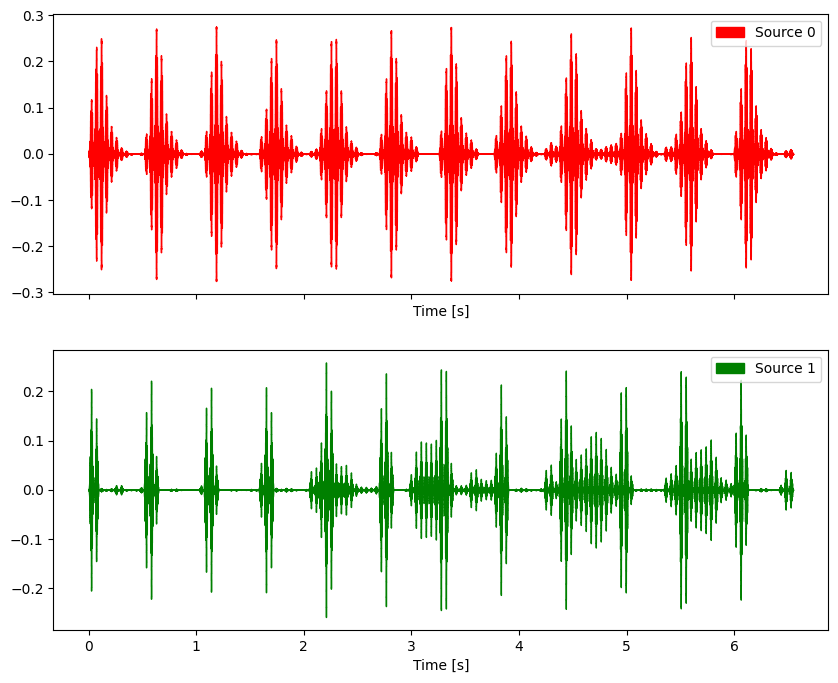

In [37]:
import soundfile as sf

# Define the number of sources
S = 2

# Create empty lists to store the reconstructed sources
reconstructed_sources = []

for i in range(S):
    # Reconstruct the source using the learned matrices W and H
    source_i = W[:, i:i+1] @ H[i:i+1, :]
    
    # Convert the source to a time-domain waveform
    source_waveform = librosa.istft(source_i, n_fft=FRAME, hop_length=HOP)
    
    # Append the reconstructed source to the list
    reconstructed_sources.append(source_waveform)

# Plot the reconstructed waveforms
colors = ['r', 'g', 'b', 'c']
fig, ax = plt.subplots(nrows=S, ncols=1, sharex=True, figsize=(10, 8))
for i in range(S):
    librosa.display.waveshow(reconstructed_sources[i], sr=sr, color=colors[i], ax=ax[i], label=f'Source {i}', x_axis='time')
    ax[i].set(xlabel='Time [s]')
    ax[i].legend()

# Play the reconstructed sources
for i, source_waveform in enumerate(reconstructed_sources):
    sf.write(f'reconstructed_source_{i}.wav', source_waveform, sr)

# Display the reconstructed sources
for i in range(S):
    ipd.display(f"Reconstructed Source {i}", ipd.Audio(reconstructed_sources[i], rate=sr))


/tmp/ipykernel_20/2765873190.py:6: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(superimposed_sources, sr=sr, color='m', label='Superimposed Sources', x_axis='time')


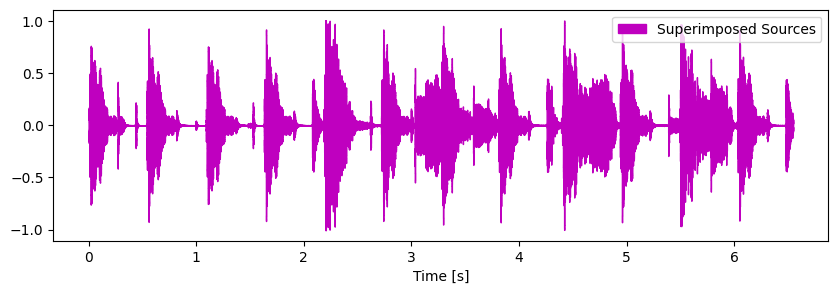

In [38]:
# Combine the two sources
superimposed_sources = reconstructed_sounds[0] + reconstructed_sounds[1]

# Plot the superimposed waveform of the two separated sources
plt.figure(figsize=(10, 3))
librosa.display.waveshow(superimposed_sources, sr=sr, color='m', label='Superimposed Sources', x_axis='time')
plt.xlabel('Time [s]')
plt.legend()
plt.show()

In [39]:
ipd.Audio(superimposed_sources,rate = sr)

In [40]:
# reconstructed_sources.shape

In [41]:
from sklearn.metrics import mean_squared_error
superimposed_sound = sum(reconstructed_sources)
print(superimposed_sound.shape)
# # Plot the superimposed waveform
# plt.figure(figsize=(10, 3))
# librosa.display.waveshow(superimposed_sound, sr=sr, color='m', label='Superimposed Sound', x_axis='time')
# plt.xlabel('Time [s]')
# plt.legend()
# plt.show()

# from sklearn.metrics import mean_squared_error
# from sklearn.metrics.pairwise import cosine_similarity
# min_length = min(len(audio_sound), len(superimposed_sound))
# audio_sound = audio_sound[:min_length]
# superimposed_sound = superimposed_sound[:min_length]

# # Calculate the MSE between the original sound and the superimposed sound
# mse_superimposed = mean_squared_error(audio_sound, superimposed_sound)

# # Calculate the MSE between the original sound and each separated sound
# mse_individual = []
# for i in range(S):
#     # Truncate or resize the separated sound to match the length of 'audio_sound'
#     reconstructed_sources = reconstructed_sources[i][:min_length]
#     mse = mean_squared_error(audio_sound, reconstructed_sources)
#     mse_individual.append(mse)

# # Print or use the MSE scores to measure resemblance
# print(f"MSE between Original Sound and Superimposed Sound: {mse_superimposed}")

for i in range(S):
    print(f"MSE between Original Sound and Source {i}: {mse_individual[i]}")
    
cosine_sim = cosine_similarity(audio_sound.reshape(1, -1), superimposed_sound.reshape(1, -1))

print(f"Cosine Similarity between Original Sound and Superimposed Sound: {cosine_sim[0, 0]}")

(36096,)
MSE between Original Sound and Source 0: 0.015281783208334348
MSE between Original Sound and Source 1: 0.02046665089142959
Cosine Similarity between Original Sound and Superimposed Sound: 0.08043371140956879


In [42]:
# Plot the cost function


## Neural network reconstruction

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the NMF model with non-negativity constraints
class NMF(nn.Module):
    def __init__(self, K, S):
        super(NMF, self).__init__()
        self.W = nn.Parameter(torch.rand(K, S))  # Initialize W as a learnable parameter
        self.H = nn.Parameter(torch.rand(S, N))  # Initialize H as a learnable parameter
        self.beta = 2  # Choose your beta value (2 for Euclidean)
        self.relu = nn.ReLU()  # Apply ReLU to enforce non-negativity

    def forward(self, V):
        WH = torch.mm(self.W, self.H)
        WH = self.relu(WH)  # Apply ReLU to enforce non-negativity
        cost = self.compute_cost(V, WH)
        return WH, cost

    def compute_cost(self, V, WH):
        if self.beta == 0:
            return torch.sum(V / WH - torch.log(V / WH) - 1)
        elif self.beta == 1:
            return torch.sum(V * torch.log(V / WH) + (WH - V))
        elif self.beta == 2:
            return 0.5 * torch.norm(WH - V)

# Prepare the data (similar to your previous code)
epsilon = 1e-10
V = torch.Tensor(sound_stft_Magnitude + epsilon)
K, N = V.shape
S = 2

# Create the NMF model
model = NMF(K, S)

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Hyperparameters for L0 and L2 regularization
l0_lambda = 1
l2_lambda = 0.01

# Lists to store the loss values for plotting
l0_loss_list = []
l2_loss_list = []

# Training loop
threshold = 0.05
MAXITER = 10000
for iteration in range(MAXITER):
    WH, cost = model(V)
    
    # Calculate L2 loss
    l2_loss = 0.5 * torch.norm(WH - V)
    
    # Calculate L0 loss
    l0_loss = torch.sum((model.W != 0).float()) + torch.sum((model.H != 0).float())
    
    # Combine the beta-divergence loss, L0 loss, and L2 loss
    loss = cost + l0_lambda * l0_loss + l2_lambda * l2_loss
    
    # Update W and H using gradient descent with non-negativity constraints
    optimizer.zero_grad()
    loss.backward()
    
    # Enforce non-negativity constraints
    for param in model.parameters():
        param.data = param.data.clamp(min=0)
    
    optimizer.step()

    # Append L0 and L2 loss values to the lists
    l0_loss_list.append(l0_loss.item())
    l2_loss_list.append(l2_loss.item())
    
    # Compute the total cost
    total_cost = cost.item() + l0_lambda * l0_loss.item() + l2_lambda * l2_loss.item()
    
    if total_cost < threshold:
        print(f"Converged after {iteration + 1} iterations.")
        break

    if iteration % 100 == 0:
        print(f"Iteration {iteration + 1}: Total Cost = {total_cost:.6f}")

# Get the factorized matrices
W = model.W.detach().numpy()
H = model.H.detach().numpy()

Iteration 1: Total Cost = 1061.968684
Iteration 101: Total Cost = 1054.280149
Iteration 201: Total Cost = 1042.273885
Iteration 301: Total Cost = 1022.991648
Iteration 401: Total Cost = 996.580585
Iteration 501: Total Cost = 972.120156
Iteration 601: Total Cost = 959.351599
Iteration 701: Total Cost = 954.390847
Iteration 801: Total Cost = 951.496205
Iteration 901: Total Cost = 948.199942
Iteration 1001: Total Cost = 943.137767
Iteration 1101: Total Cost = 935.334278
Iteration 1201: Total Cost = 925.176031
Iteration 1301: Total Cost = 916.296959
Iteration 1401: Total Cost = 911.433706
Iteration 1501: Total Cost = 909.273470
Iteration 1601: Total Cost = 908.304542
Iteration 1701: Total Cost = 907.771855
Iteration 1801: Total Cost = 907.427619
Iteration 1901: Total Cost = 907.201380
Iteration 2001: Total Cost = 907.047667
Iteration 2101: Total Cost = 906.942685
Iteration 2201: Total Cost = 906.871985
Iteration 2301: Total Cost = 906.823855
Iteration 2401: Total Cost = 906.791276
Iteratio

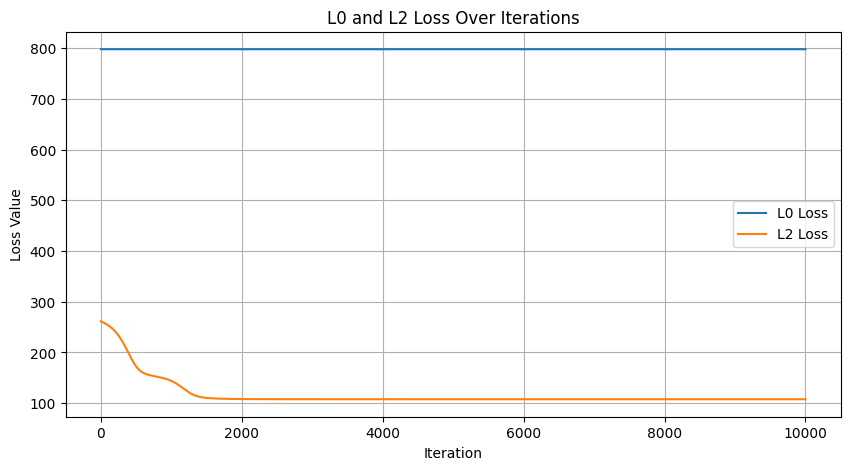

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(l0_loss_list) + 1), l0_loss_list, label='L0 Loss')
plt.plot(range(1, len(l2_loss_list) + 1), l2_loss_list, label='L2 Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.legend()
plt.title('L0 and L2 Loss Over Iterations')
plt.grid(True)
plt.show()

/tmp/ipykernel_20/2631031997.py:23: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(reconstructed_sources[i], sr=sr, color=colors[i], ax=ax[i], label=f'Source {i}', x_axis='time')


'Reconstructed Source 0'

'Reconstructed Source 1'

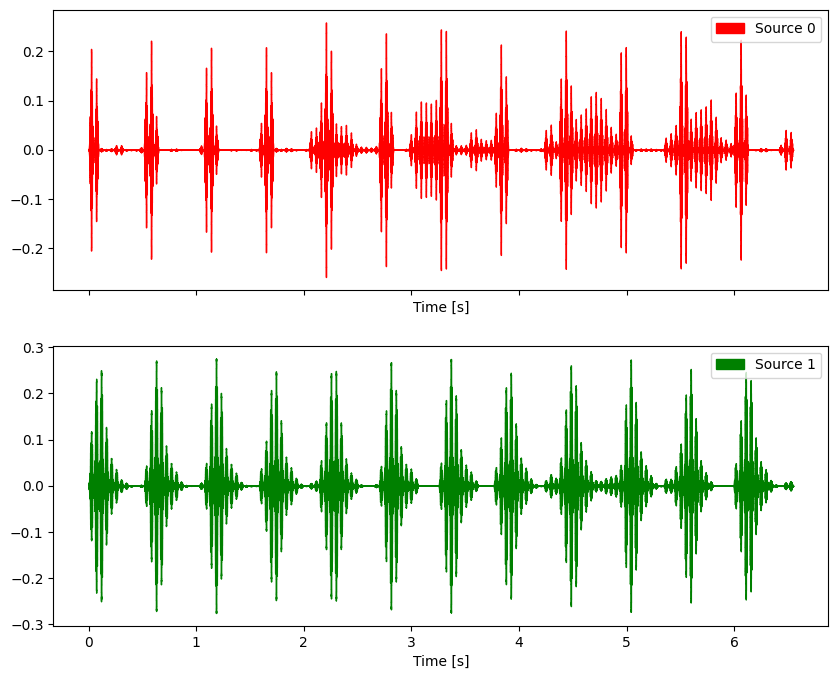

In [45]:
import soundfile as sf

# Define the number of sources
S = 2

# Create empty lists to store the reconstructed sources
reconstructed_sources = []

for i in range(S):
    # Reconstruct the source using the learned matrices W and H
    source_i = W[:, i:i+1] @ H[i:i+1, :]
    
    # Convert the source to a time-domain waveform
    source_waveform = librosa.istft(source_i, n_fft=FRAME, hop_length=HOP)
    
    # Append the reconstructed source to the list
    reconstructed_sources.append(source_waveform)

# Plot the reconstructed waveforms
colors = ['r', 'g', 'b', 'c']
fig, ax = plt.subplots(nrows=S, ncols=1, sharex=True, figsize=(10, 8))
for i in range(S):
    librosa.display.waveshow(reconstructed_sources[i], sr=sr, color=colors[i], ax=ax[i], label=f'Source {i}', x_axis='time')
    ax[i].set(xlabel='Time [s]')
    ax[i].legend()

# Play the reconstructed sources
for i, source_waveform in enumerate(reconstructed_sources):
    sf.write(f'reconstructed_source_{i}.wav', source_waveform, sr)

# Display the reconstructed sources
for i in range(S):
    ipd.display(f"Reconstructed Source {i}", ipd.Audio(reconstructed_sources[i], rate=sr))


## Experiment with L1 AND L2 (WIERD RESULT)

Iteration 1: Total Cost = 930.200684
Iteration 101: Total Cost = 537.641706
Iteration 201: Total Cost = 536.727390
Iteration 301: Total Cost = 536.559108
Iteration 401: Total Cost = 538.423872
Iteration 501: Total Cost = 535.427868
Iteration 601: Total Cost = 538.004572
Iteration 701: Total Cost = 536.784291
Iteration 801: Total Cost = 536.326067
Iteration 901: Total Cost = 537.480624
Iteration 1001: Total Cost = 535.558240
Iteration 1101: Total Cost = 535.035151
Iteration 1201: Total Cost = 534.576774
Iteration 1301: Total Cost = 535.407436
Iteration 1401: Total Cost = 537.807658
Iteration 1501: Total Cost = 534.715472
Iteration 1601: Total Cost = 534.575960
Iteration 1701: Total Cost = 534.715472
Iteration 1801: Total Cost = 534.575960
Iteration 1901: Total Cost = 534.715472
Iteration 2001: Total Cost = 534.575960
Iteration 2101: Total Cost = 534.715472
Iteration 2201: Total Cost = 534.575960
Iteration 2301: Total Cost = 534.715472
Iteration 2401: Total Cost = 534.575960
Iteration 25

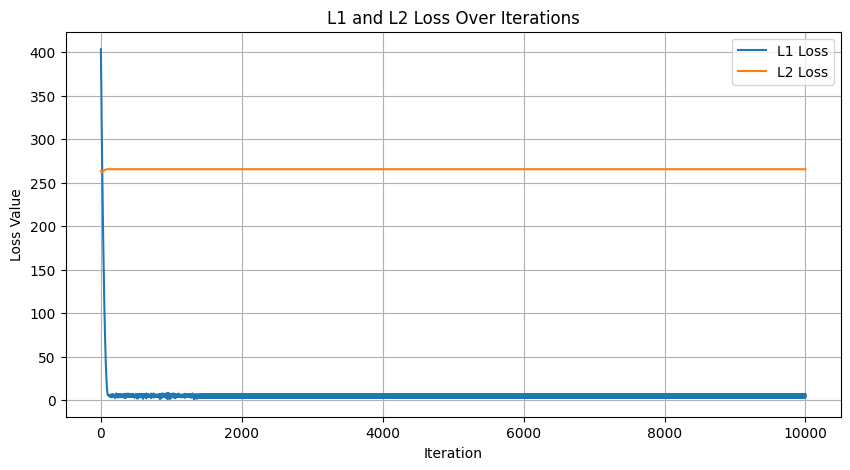

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the NMF model with non-negativity constraints
class NMF(nn.Module):
    def __init__(self, K, S):
        super(NMF, self).__init__()
        self.W = nn.Parameter(torch.rand(K, S))  # Initialize W as a learnable parameter
        self.H = nn.Parameter(torch.rand(S, N))  # Initialize H as a learnable parameter
        self.beta = 2  # Choose your beta value (2 for Euclidean)
        self.relu = nn.ReLU()  # Apply ReLU to enforce non-negativity

    def forward(self, V):
        WH = torch.mm(self.W, self.H)
        WH = self.relu(WH)  # Apply ReLU to enforce non-negativity
        cost = self.compute_cost(V, WH)
        return WH, cost

    def compute_cost(self, V, WH):
        if self.beta == 0:
            return torch.sum(V / WH - torch.log(V / WH) - 1)
        elif self.beta == 1:
            return torch.sum(V * torch.log(V / WH) + (WH - V))
        elif self.beta == 2:
            return 0.5 * torch.norm(WH - V)

# Prepare the data (similar to your previous code)
epsilon = 1e-10
V = torch.Tensor(sound_stft_Magnitude + epsilon)
K, N = V.shape
S = 2

# Create the NMF model
model = NMF(K, S)

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Hyperparameters for L1 and L2 regularization
l1_lambda = 1
l2_lambda = 1

# Lists to store the loss values for plotting
l1_loss_list = []
l2_loss_list = []

# Training loop
threshold = 0.05
MAXITER = 10000
for iteration in range(MAXITER):
    WH, cost = model(V)
    
    # Calculate L2 loss
    l2_loss = 0.5 * torch.norm(WH - V)
    
    # Calculate L1 loss
    l1_loss = torch.sum(torch.abs(model.W)) + torch.sum(torch.abs(model.H))
    
    # Combine the beta-divergence loss, L1 loss, and L2 loss
    loss = cost + l1_lambda * l1_loss + l2_lambda * l2_loss
    
    # Update W and H using gradient descent with non-negativity constraints
    optimizer.zero_grad()
    loss.backward()
    
    # Enforce non-negativity constraints
    for param in model.parameters():
        param.data = param.data.clamp(min=0)
    
    optimizer.step()

    # Append L1 and L2 loss values to the lists
    l1_loss_list.append(l1_loss.item())
    l2_loss_list.append(l2_loss.item())
    
    # Compute the total cost
    total_cost = cost.item() + l1_lambda * l1_loss.item() + l2_lambda * l2_loss.item()
    
    if total_cost < threshold:
        print(f"Converged after {iteration + 1} iterations.")
        break

    if iteration % 100 == 0:
        print(f"Iteration {iteration + 1}: Total Cost = {total_cost:.6f}")

# Get the factorized matrices
W = model.W.detach().numpy()
H = model.H.detach().numpy()

# Now, you can use W and H to filter and reconstruct the sources as in your previous code.

# Plot L1 and L2 loss over iterations
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(l1_loss_list) + 1), l1_loss_list, label='L1 Loss')
plt.plot(range(1, len(l2_loss_list) + 1), l2_loss_list, label='L2 Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.legend()
plt.title('L1 and L2 Loss Over Iterations')
plt.grid(True)
plt.show()


/tmp/ipykernel_20/2631031997.py:23: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(reconstructed_sources[i], sr=sr, color=colors[i], ax=ax[i], label=f'Source {i}', x_axis='time')


'Reconstructed Source 0'

'Reconstructed Source 1'

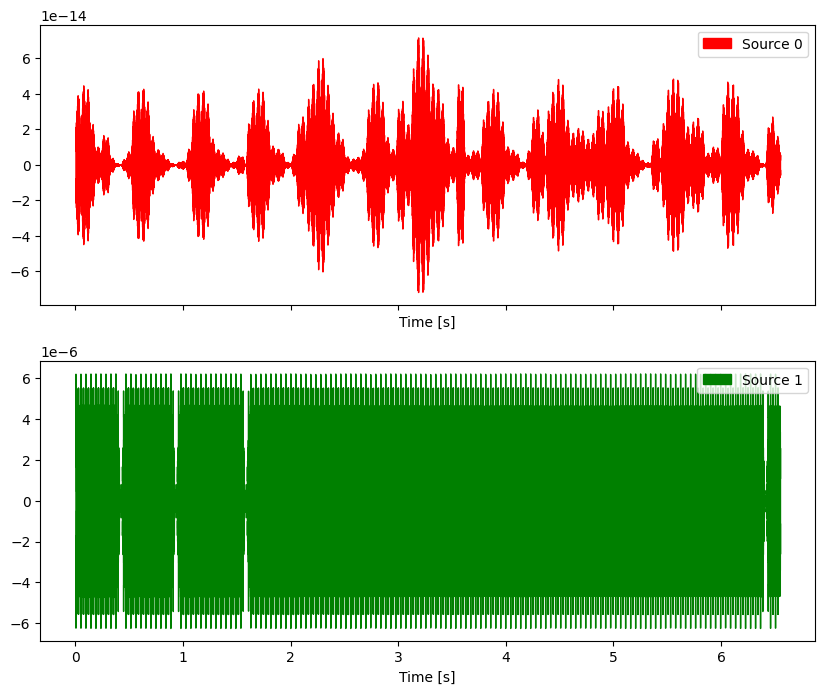

In [47]:
import soundfile as sf

# Define the number of sources
S = 2

# Create empty lists to store the reconstructed sources
reconstructed_sources = []

for i in range(S):
    # Reconstruct the source using the learned matrices W and H
    source_i = W[:, i:i+1] @ H[i:i+1, :]
    
    # Convert the source to a time-domain waveform
    source_waveform = librosa.istft(source_i, n_fft=FRAME, hop_length=HOP)
    
    # Append the reconstructed source to the list
    reconstructed_sources.append(source_waveform)

# Plot the reconstructed waveforms
colors = ['r', 'g', 'b', 'c']
fig, ax = plt.subplots(nrows=S, ncols=1, sharex=True, figsize=(10, 8))
for i in range(S):
    librosa.display.waveshow(reconstructed_sources[i], sr=sr, color=colors[i], ax=ax[i], label=f'Source {i}', x_axis='time')
    ax[i].set(xlabel='Time [s]')
    ax[i].legend()

# Play the reconstructed sources
for i, source_waveform in enumerate(reconstructed_sources):
    sf.write(f'reconstructed_source_{i}.wav', source_waveform, sr)

# Display the reconstructed sources
for i in range(S):
    ipd.display(f"Reconstructed Source {i}", ipd.Audio(reconstructed_sources[i], rate=sr))


In [48]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# import matplotlib.pyplot as plt

# # Define the NMF model with non-negativity constraints
# class NMF(nn.Module):
#     def __init__(self, K, S):
#         super(NMF, self).__init__()
#         self.W = nn.Parameter(torch.rand(K, S))  # Initialize W as a learnable parameter
#         self.H = nn.Parameter(torch.rand(S, N))  # Initialize H as a learnable parameter
#         self.beta = 2  # Choose your beta value (2 for Euclidean)
#         self.relu = nn.ReLU()  # Apply ReLU to enforce non-negativity
# #         self.V=torch.Tensor(sound_stft_Magnitude + epsilon)

#     def forward(self, V):
#         WH = torch.mm(self.W, self.H)
#         WH = self.relu(WH)  # Apply ReLU to enforce non-negativity
#         cost = self.compute_cost(V, WH)
#         return WH, cost

#     def compute_cost(self, V, WH):
#         if self.beta == 0:
#             return torch.sum(V / WH - torch.log(V / WH) - 1)
#         elif self.beta == 1:
#             return torch.sum(V * torch.log(V / WH) + (WH - V))
#         elif self.beta == 2:
#             return 0.5 * torch.norm(WH - V)

# # Prepare the data (similar to your previous code)
# epsilon = 1e-10
# V = torch.Tensor(sound_stft_Magnitude + epsilon)
# K, N = V.shape
# S = 2

# # Grid of hyperparameters to explore
# l1_lambda_values = [0.001, 0.01, 0.1]
# l2_lambda_values = [0.001, 0.01, 0.1]

# # Dictionary to store loss values for each combination
# loss_values = {}

# # Training loop for different hyperparameters
# for l1_lambda in l1_lambda_values:
#     for l2_lambda in l2_lambda_values:
#         # Create the NMF model
#         model = NMF(K, S)

#         # Define the optimizer
#         optimizer = optim.SGD(model.parameters(), lr=0.01)

#         # Lists to store the loss values for plotting
#         l1_loss_list = []
#         l2_loss_list = []

#         # Training loop
#         threshold = 0.05
#         MAXITER = 10000
#         for iteration in range(MAXITER):
#             WH, cost = model(V)

#             # Calculate L2 loss
#             l2_loss = 0.5 * torch.norm(WH - V)

#             # Calculate L1 loss
#             l1_loss = (torch.sum(torch.abs(model.W)) + torch.sum(torch.abs(model.H)))

#             # Combine the beta-divergence loss, L1 loss, and L2 loss
#             loss = cost + l1_lambda * l1_loss + l2_lambda * l2_loss

#             # Update W and H using gradient descent with non-negativity constraints
#             optimizer.zero_grad()
#             loss.backward()

#             # Enforce non-negativity constraints
#             for param in model.parameters():
#                 param.data = param.data.clamp(min=0)

#             optimizer.step()

#             # Append L1 and L2 loss values to the lists
#             l1_loss_list.append(l1_loss.item())
#             l2_loss_list.append(l2_loss.item())

#             # Compute the total cost
#             total_cost = cost.item() + l1_lambda * l1_loss.item() + l2_lambda * l2_loss.item()

#             if total_cost < threshold:
#                 print(f"Converged after {iteration + 1} iterations.")
#                 break

#         # Store the loss values for this combination of hyperparameters
#         loss_values[(l1_lambda, l2_lambda)] = (l1_loss_list, l2_loss_list)

# # Plot L1 and L2 loss for different hyperparameter combinations
# for (l1_lambda, l2_lambda), (l1_loss_list, l2_loss_list) in loss_values.items():
#     plt.figure(figsize=(10, 5))
#     plt.plot(range(1, len(l1_loss_list) + 1), l1_loss_list, label=f'L1 Loss (lambda={l1_lambda})')
#     plt.plot(range(1, len(l2_loss_list) + 1), l2_loss_list, label=f'L2 Loss (lambda={l2_lambda})')
#     plt.xlabel('Iteration')
#     plt.ylabel('Loss Value')
#     plt.legend()
#     plt.title(f'L1 and L2 Loss Over Iterations (lambda={l1_lambda}, {l2_lambda})')
#     plt.grid(True)
#     plt.show()


In [49]:
# import soundfile as sf

# # Define the number of sources
# S = 2

# # Create empty lists to store the reconstructed sources
# reconstructed_sources = []

# for i in range(S):
#     # Reconstruct the source using the learned matrices W and H
#     source_i = W[:, i:i+1] @ H[i:i+1, :]
    
#     # Convert the source to a time-domain waveform
#     source_waveform = librosa.istft(source_i, n_fft=FRAME, hop_length=HOP)
    
#     # Append the reconstructed source to the list
#     reconstructed_sources.append(source_waveform)

# # Plot the reconstructed waveforms
# colors = ['r', 'g', 'b', 'c']
# fig, ax = plt.subplots(nrows=S, ncols=1, sharex=True, figsize=(10, 8))
# for i in range(S):
#     librosa.display.waveshow(reconstructed_sources[i], sr=sr, color=colors[i], ax=ax[i], label=f'Source {i}', x_axis='time')
#     ax[i].set(xlabel='Time [s]')
#     ax[i].legend()

# # Play the reconstructed sources
# for i, source_waveform in enumerate(reconstructed_sources):
#     sf.write(f'reconstructed_source_{i}.wav', source_waveform, sr)

# # Display the reconstructed sources
# for i in range(S):
#     ipd.display(f"Reconstructed Source {i}", ipd.Audio(reconstructed_sources[i], rate=sr))
